# Appendix: Autoregressive models

The goal of [autoregressive models](https://en.wikipedia.org/wiki/Autoregressive_model) is to characterize 
$p(\boldsymbol{\mathsf{x}}_t \mid \boldsymbol{\mathsf{x}}_1, \ldots, \boldsymbol{\mathsf{x}}_{t-1})$, i.e. the next element is estimated using previous elements of the same sequence. Note that the 
entire distribution is generally hard to compute, and we may be content with $\mathbb{E}\left[\boldsymbol{\mathsf{x}}_t \mid \boldsymbol{\mathsf{x}}_1, \ldots, \boldsymbol{\mathsf{x}}_{t-1}\right]$, i.e. estimating the average value of the next element.
One issue is that the length of sequences increase with the amount of data that we encounter.
Much of sequence modeling literature revolve around techniques for dealing with 
increasing context size to predict the next token or certain statistics of the distribution $p(\boldsymbol{\mathsf{x}}_t \mid \boldsymbol{\mathsf{x}}_1, \ldots, \boldsymbol{\mathsf{x}}_{t-1}).$

A natural strategy is to just ignore more data, i.e. only use past $\tau$ observations, so that we estimate $p(\boldsymbol{\mathsf{x}}_t \mid \boldsymbol{\mathsf{x}}_{t-\tau}, \ldots, \boldsymbol{\mathsf{x}}_{t-1}).$ This is a [Markovian assumption](https://en.wikipedia.org/wiki/Markov_model) where we assume that the past $\tau$ elements are sufficient to approximate the next element. This makes sense especially for phenomenon where long-range dependency is rare, or that the importance of long-range dependency decays quickly with time.
In this case, all inputs are of length $\tau$
which allows us to train any linear model or deep network that requires fixed-length vectors as inputs.

## Autoregressive linear model

Let's train an autogressive *linear* model with 4th order Markov condition.

In [1]:
import torch
torch.manual_seed(42)

B = 16
T = 1000
N = 600
tau = 4
t = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * t) + torch.randn(T) * 0.2

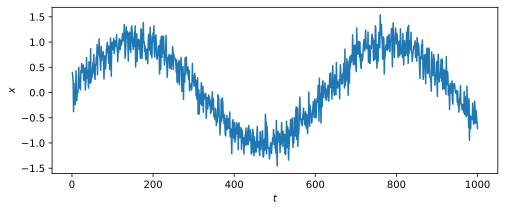

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = "svg"
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 3))
plt.plot(t, x)
plt.ylabel("$x$")
plt.xlabel("$t$");

Our task is to model $[\boldsymbol{\mathsf{x}}_{t - \tau}, \ldots, \boldsymbol{\mathsf{x}}_{t - 1}] \mapsto \boldsymbol{\mathsf{x}}_{t}.$ Here we sample windows of fixed length $\tau = 4$:

In [3]:
def build_dataset(tau: int):
    # stack offsets each with length T - tau
    f = torch.stack([x[i: T-tau+i] for i in range(tau)], 1)
    y = x[tau: ].reshape(-1, 1)
    return f, y


f, y = build_dataset(tau=4)
print(f.shape)
print(f)

torch.Size([996, 4])
tensor([[ 0.3954,  0.3175,  0.2101, -0.3811],
        [ 0.3175,  0.2101, -0.3811,  0.1857],
        [ 0.2101, -0.3811,  0.1857, -0.1869],
        ...,
        [-0.3731, -0.6096, -0.3532, -0.3788],
        [-0.6096, -0.3532, -0.3788, -0.5344],
        [-0.3532, -0.3788, -0.5344, -0.6116]])


We will discard $\tau$ elements to get the targets, which start with $t = \tau  + 1.$

In [4]:
y[0]    # [0.3954, 0.3175,  0.2101, -0.3811,] 0.2197 <- first target

tensor([0.1857])

Creating the data loader:

In [5]:
from torch.utils.data import TensorDataset, DataLoader

data = TensorDataset(f[:-100], y[:-100])
inp, tgt = next(iter(data))
inp, tgt

(tensor([ 0.3954,  0.3175,  0.2101, -0.3811]), tensor([0.1857]))

Training a linear model which uses previous $\tau = 4$ points as input:

In [6]:
import torch.nn as nn

def train_model(
    f: torch.tensor, 
    y: torch.tensor,
    tau: int
):
    """Train a tau-order linear Markov model."""
    data = TensorDataset(f, y)
    model = nn.Sequential(nn.Linear(tau, 1))
    optim = torch.optim.SGD(model.parameters(), lr=0.01)
    for _ in range(3):
        for u, v in DataLoader(data, batch_size=16, shuffle=True):
            loss = ((model(u) - v) ** 2).mean()
            loss.backward()
            optim.step()
            optim.zero_grad()
    
    return model


model = train_model(f[:-100], y[:-100], tau=4)

The model does not simple average:

In [7]:
print(list(model.parameters())[0])

Parameter containing:
tensor([[-0.1419,  0.3067,  0.4141,  0.4178]], requires_grad=True)


Let's compare with a baseline averaging model:

In [8]:
y_baseline = f.mean(dim=1)

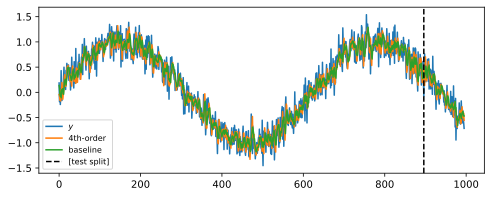

In [9]:
plt.figure(figsize=(8, 3))
plt.plot(y, label="$y$")
plt.plot(model(f).reshape(-1).tolist(), label="4th-order")
plt.plot(y_baseline, label="baseline")
plt.axvline(len(f[:-100]), linestyle="dashed", color="k", label="[test split]")
plt.legend(fontsize=8);

Also train a first-order Markov model for good fun:

In [10]:
# First order markov model
f1, y1 = build_dataset(tau=1)
model1 = train_model(f1[:-100], y1[:-100], tau=1)

Test performance:

In [11]:
print("Mean squared error")
print(f"  (4th-order)  {((model(f[-100:])   - y [-100:]) ** 2).mean().item():.3f}")
print(f"  (1st-order)  {((model1(f1[-100:]) - y1[-100:]) ** 2).mean().item():.3f}")
print(f"  (base-line)  {((y_baseline[-100:] - y [-100:]) ** 2).mean().item():.3f}")

Mean squared error
  (4th-order)  0.054
  (1st-order)  0.094
  (base-line)  0.231


<br>

## Look-ahead predictions

Suppose we have measurement data up to $t = 204$ and we want to predict $t = 205, \ldots, 209$. To do this we can reuse predictions. Beginning precisely $t = 209$, we have to use solely predicted values instead of observed data:

$$
\begin{aligned}
& \hat{x}_{205}=f\left(x_{201}, x_{202}, x_{203}, x_{204}\right) \\
& \hat{x}_{206}=f\left(x_{202}, x_{203}, x_{204}, \hat{x}_{205}\right) \\
& \hat{x}_{207}=f\left(x_{203}, x_{204}, \hat{x}_{205}, \hat{x}_{206}\right) \\
& \hat{x}_{208}=f\left(x_{204}, \hat{x}_{205}, \hat{x}_{206}, \hat{x}_{207}\right) \\
& \hat{x}_{209}=f\left(\hat{x}_{205}, \hat{x}_{206}, \hat{x}_{207}, \hat{x}_{208}\right)
\end{aligned}
$$

This approach immediately accumulates errors and we get nonsense predictions:

In [12]:
t0 = 201
preds = []
k_max = 800
ctx = x[t0: t0 + tau].tolist()
for i in range(k_max):
    x_hat = model(torch.tensor(ctx).reshape(1, -1))[0]
    preds.append(x_hat.item())
    ctx = ctx[1:] + [x_hat]

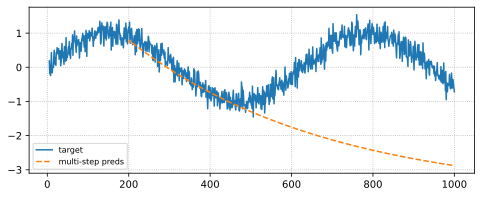

In [13]:
plt.figure(figsize=(8, 3))
plt.plot(t[tau:], y, label="target")
plt.plot(range(t0, t0 + k_max), preds, label="multi-step preds", linestyle="dashed")
plt.grid(linestyle="dotted")
plt.legend(fontsize=8);